In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck'] # here, 0 airplane, 2 bird

In [3]:
from torchvision import datasets, transforms
data_path = '/home/hyunsu/Documents/data_ML/cifar10/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) # make tuple
          for img, label in cifar10 
          if label in [0, 2]] # do if airplane or bird
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,  # 32 x 32 x 3 feature
                512,   # <2>
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # <2>
                n_out, # <3>
            )
        )

In [7]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [8]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [9]:
softmax(x).sum()

tensor(1.)

In [10]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]]) # 2 x 3

softmax(x), x.mean(dim=1) # to understand the dimension


(tensor([[0.0900, 0.2447, 0.6652],
         [0.0900, 0.2447, 0.6652]]),
 tensor([2., 2.]))

In [11]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


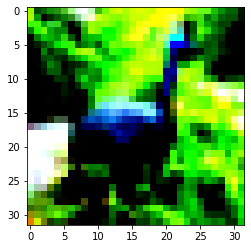

In [12]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [13]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [14]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [15]:
_, index = torch.max(out, dim=1)

index

tensor([1])

In [16]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

truth = torch.zeros((4,2)) # one-hot encoding
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [17]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [18]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [19]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [20]:
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [21]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison

tensor([0.0750, 0.1500, 0.2500, 0.4750])

In [22]:
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [23]:
nll_comparison = torch.tensor([neg_log_likelihood(o) 
                               for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [24]:
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [25]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x), log_softmax(x)

(tensor([[0., 1.]]), tensor([[-104.,    0.]]))

In [26]:
torch.log(softmax(x)) # the reason to use logsoftmax instead of softmax

tensor([[-inf, 0.]])

In [27]:
log_softmax(x)

tensor([[-104.,    0.]])

In [28]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [29]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [30]:
loss = nn.NLLLoss()

In [31]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.5077, grad_fn=<NllLossBackward0>)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


device(type='cuda')

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1)).to(device)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0).to(device))
        loss = loss_fn(out, torch.tensor([label]).to(device))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 6.104034
Epoch: 1, Loss: 5.614705
Epoch: 2, Loss: 10.030086
Epoch: 3, Loss: 4.192981
Epoch: 4, Loss: 3.284071
Epoch: 5, Loss: 9.248923
Epoch: 6, Loss: 5.384418
Epoch: 7, Loss: 3.068453
Epoch: 8, Loss: 11.755852
Epoch: 9, Loss: 10.503537
Epoch: 10, Loss: 1.813431
Epoch: 11, Loss: 8.145979
Epoch: 12, Loss: 7.243825
Epoch: 13, Loss: 3.537252
Epoch: 14, Loss: 5.244114
Epoch: 15, Loss: 7.443619
Epoch: 16, Loss: 4.032690
Epoch: 17, Loss: 3.282646
Epoch: 18, Loss: 7.826687
Epoch: 19, Loss: 13.519883
Epoch: 20, Loss: 8.205056
Epoch: 21, Loss: 12.670047
Epoch: 22, Loss: 9.744849
Epoch: 23, Loss: 3.434032
Epoch: 24, Loss: 11.118172
Epoch: 25, Loss: 14.953550
Epoch: 26, Loss: 7.084696
Epoch: 27, Loss: 20.254307
Epoch: 28, Loss: 13.225882
Epoch: 29, Loss: 7.669613
Epoch: 30, Loss: 12.838577
Epoch: 31, Loss: 10.905982
Epoch: 32, Loss: 18.076811
Epoch: 33, Loss: 12.677045
Epoch: 34, Loss: 13.437262
Epoch: 35, Loss: 13.721916
Epoch: 36, Loss: 10.082571
Epoch: 37, Loss: 12.501238
Epoch

In [36]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1)).to(device)


learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to(device))
        loss = loss_fn(outputs, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.290652
Epoch: 1, Loss: 0.596096
Epoch: 2, Loss: 0.288824
Epoch: 3, Loss: 0.372863
Epoch: 4, Loss: 0.431011
Epoch: 5, Loss: 0.509270
Epoch: 6, Loss: 0.184279
Epoch: 7, Loss: 0.458323
Epoch: 8, Loss: 0.434904
Epoch: 9, Loss: 0.281615
Epoch: 10, Loss: 0.262083
Epoch: 11, Loss: 0.378605
Epoch: 12, Loss: 0.406189
Epoch: 13, Loss: 0.323112
Epoch: 14, Loss: 0.353314
Epoch: 15, Loss: 0.297496
Epoch: 16, Loss: 0.113304
Epoch: 17, Loss: 0.233832
Epoch: 18, Loss: 0.403771
Epoch: 19, Loss: 0.265747
Epoch: 20, Loss: 0.110455
Epoch: 21, Loss: 0.148265
Epoch: 22, Loss: 0.189928
Epoch: 23, Loss: 0.356492
Epoch: 24, Loss: 0.527282
Epoch: 25, Loss: 0.309290
Epoch: 26, Loss: 0.438987
Epoch: 27, Loss: 0.235336
Epoch: 28, Loss: 0.390660
Epoch: 29, Loss: 0.052564
Epoch: 30, Loss: 0.167443
Epoch: 31, Loss: 0.433880
Epoch: 32, Loss: 0.192829
Epoch: 33, Loss: 0.094194
Epoch: 34, Loss: 0.298321
Epoch: 35, Loss: 0.147978
Epoch: 36, Loss: 0.235584
Epoch: 37, Loss: 0.175474
Epoch: 38, Loss: 0.176

In [42]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to(device))
        _, predicted = torch.max(outputs, dim=1)
        labels = labels.to(device)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999500


In [44]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to(device))
        _, predicted = torch.max(outputs, dim=1)
        labels = labels.to(device)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.811500


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2)).to(device)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to(device))
        loss = loss_fn(outputs, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.304551
Epoch: 1, Loss: 0.624621
Epoch: 2, Loss: 0.218915
Epoch: 3, Loss: 0.393432
Epoch: 4, Loss: 0.365717
Epoch: 5, Loss: 0.256471
Epoch: 6, Loss: 0.518236
Epoch: 7, Loss: 0.544386
Epoch: 8, Loss: 0.248678
Epoch: 9, Loss: 0.348357
Epoch: 10, Loss: 0.357375
Epoch: 11, Loss: 0.342049
Epoch: 12, Loss: 0.280576
Epoch: 13, Loss: 0.522524
Epoch: 14, Loss: 0.494793
Epoch: 15, Loss: 0.357507
Epoch: 16, Loss: 0.527270
Epoch: 17, Loss: 0.774763
Epoch: 18, Loss: 0.206350
Epoch: 19, Loss: 0.396299
Epoch: 20, Loss: 0.293799
Epoch: 21, Loss: 0.233297
Epoch: 22, Loss: 0.290985
Epoch: 23, Loss: 0.268711
Epoch: 24, Loss: 0.340262
Epoch: 25, Loss: 0.273507
Epoch: 26, Loss: 0.264111
Epoch: 27, Loss: 0.285662
Epoch: 28, Loss: 0.204051
Epoch: 29, Loss: 0.177308
Epoch: 30, Loss: 0.144793
Epoch: 31, Loss: 0.094282
Epoch: 32, Loss: 0.165821
Epoch: 33, Loss: 0.136289
Epoch: 34, Loss: 0.111931
Epoch: 35, Loss: 0.070409
Epoch: 36, Loss: 0.060739
Epoch: 37, Loss: 0.161899
Epoch: 38, Loss: 0.041

In [46]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to(device))
        _, predicted = torch.max(outputs, dim=1)
        labels = labels.to(device)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999800


In [47]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1).to(device))
        _, predicted = torch.max(outputs, dim=1)
        labels = labels.to(device)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.812000


In [48]:
sum([p.numel() for p in model.parameters()])

3737474

In [49]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

In [50]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

1574402

In [51]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

In [52]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

3146752

In [53]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [54]:
conv = nn.Conv2d(3, 16, kernel_size=3)

In [55]:
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [56]:
conv.bias.shape

torch.Size([16])

In [57]:
img, _ = cifar2[0]

output = conv(img.unsqueeze(0))

In [58]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


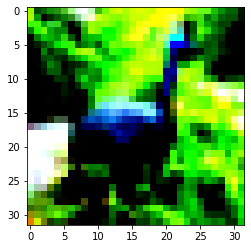

In [59]:
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.show()

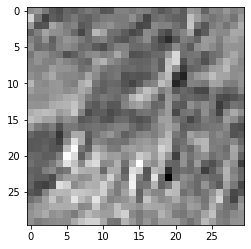

In [60]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [61]:
output.shape

torch.Size([1, 16, 30, 30])

In [62]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [63]:
output = conv(img.unsqueeze(0))

output.shape

torch.Size([1, 1, 32, 32])

In [65]:
with torch.no_grad():
    conv.bias.zero_()

In [66]:
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

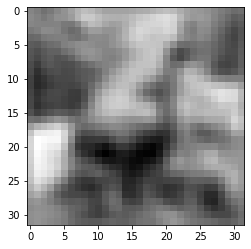

In [67]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [68]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

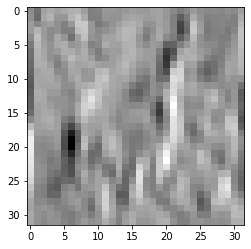

In [69]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [70]:
pool = nn.MaxPool2d(2)

In [71]:
output = pool(img.unsqueeze(0))

output.shape

torch.Size([1, 3, 16, 16])

In [73]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2))

In [79]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), # 16 x 32 x 32
            nn.Tanh(),
            nn.MaxPool2d(2), # 16 x 16 x 16
            nn.Conv2d(16, 8, kernel_size=3, padding=1), # 8 x 16 x 16
            nn.Tanh(),
            nn.MaxPool2d(2), # 8 x 8 x 8
            # torch.flatten(),
            nn.Linear(512, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [75]:
sum([p.numel() for p in model.parameters()])

18090

In [80]:
#model(img.unsqueeze(0)) # since there no flatten, you can forward this model

In [82]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # this work like flatten
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

In [83]:
model = Net()

sum([p.numel() for p in model.parameters()])

18090

In [84]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [85]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.2405, -0.0994]], grad_fn=<AddmmBackward0>)

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net().to(device)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.to(device))
        loss = loss_fn(outputs, labels.to(device))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.546526
Epoch: 1, Loss: 0.518879
Epoch: 2, Loss: 0.437984
Epoch: 3, Loss: 0.403006
Epoch: 4, Loss: 0.214272
Epoch: 5, Loss: 0.324698
Epoch: 6, Loss: 0.424224
Epoch: 7, Loss: 0.163004
Epoch: 8, Loss: 0.527817
Epoch: 9, Loss: 0.353811
Epoch: 10, Loss: 0.201866
Epoch: 11, Loss: 0.460753
Epoch: 12, Loss: 0.506434
Epoch: 13, Loss: 0.081211
Epoch: 14, Loss: 0.378655
Epoch: 15, Loss: 0.343203
Epoch: 16, Loss: 0.347149
Epoch: 17, Loss: 0.436019
Epoch: 18, Loss: 0.148665
Epoch: 19, Loss: 0.405027
Epoch: 20, Loss: 0.250077
Epoch: 21, Loss: 0.251469
Epoch: 22, Loss: 0.272347
Epoch: 23, Loss: 0.114908
Epoch: 24, Loss: 0.174334
Epoch: 25, Loss: 0.355608
Epoch: 26, Loss: 0.416404
Epoch: 27, Loss: 0.108453
Epoch: 28, Loss: 0.264927
Epoch: 29, Loss: 0.150396
Epoch: 30, Loss: 0.188177
Epoch: 31, Loss: 0.136211
Epoch: 32, Loss: 0.177020
Epoch: 33, Loss: 0.324992
Epoch: 34, Loss: 0.280588
Epoch: 35, Loss: 0.060705
Epoch: 36, Loss: 0.317196
Epoch: 37, Loss: 0.172130
Epoch: 38, Loss: 0.061

In [88]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.to(device))
        _, predicted = torch.max(outputs, dim=1)
        labels = labels.to(device)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.950000


In [89]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.to(device))
        _, predicted = torch.max(outputs, dim=1)
        labels = labels.to(device)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.892500


In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net().to(device)
sum([p.numel() for p in model.parameters()])

18090

In [91]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Linear(8*8*8, 32), # no flatten, this code doesn't work
            nn.Tanh(),
            nn.Linear(32, 2))

model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)